## 4) Feature Engineering
### 4.1) 	Whether any transformations required
### 4.2) 	Scaling the data
### 4.3) 	Feature selection 
### 4.4) 	Dimensionality reduction

## 4.1) Whether any transformations required

Data transformation is used when data needs to be converted to match that of the destination system.
**We have performed label encoding to make our data suitable for model building.**
**Target variable, Target is defined as follows:
0 - if df['readmitted'] ==  '>30') or (df['readmitted'] == 'NO')
1 - if df['readmitted'] == '<30'

### 4.2) 	Scaling the data

**Scaling a continuous variable** is a meaningful process. But doing the same with columns containing 0 or 1 does not seem to be ideal. The dummies will not have their "fair share" of influencing the calibrated model.
Unfortunately, there are no continuous numerical variable in our dataset and hence there is no need for **scaling**.

### 4.3) 	Feature selection 

### Automatically select the number of features

The RFE method is available via the RFE class in scikit-learn.

RFE is a transform. To use it, first the class is configured with the chosen algorithm specified via the “estimator” argument and the number of features to select via the “n_features_to_select” argument.

The algorithm must provide a way to calculate important scores, such as a decision tree. The algorithm used in RFE does not have to be the algorithm that is fit on the selected features; different algorithms can be used.

Once configured, the class must be fit on a training dataset to select the features by calling the fit() function. After the class is fit, the choice of input variables can be seen via the “support_” attribute that provides a True or False for each input variable.

It can then be applied to the dataset by calling the transform() function.

### 4.4) 	Dimensionality reduction

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import time
from datetime import timedelta

start_time = time.time()

### To print the elapsed time, first get the start time

In [10]:
# ! pip install pydotplus
# ! pip install pydot
! pip install xgboost  

In [11]:
import pandas                         as     pd
import numpy                          as     np
import seaborn                        as     sns
import matplotlib.pyplot              as     plt
import statsmodels.api                as     sm
import sys, os, six

from   sklearn                        import  metrics 
from   sklearn.metrics                import  classification_report
from   sklearn.metrics                import  confusion_matrix
from   sklearn.metrics                import  roc_curve, auc
from   sklearn.model_selection        import  train_test_split, cross_val_score
# !pip install pydotplus ### if not available in the Python Environment
import pydotplus

# !pip install pydot ### if not available in the Python Environment
import pydot

## ! pip install  graphviz  ### if not available in the Python Environment

In [12]:
from   sklearn                  import  tree
from   sklearn.tree             import  DecisionTreeClassifier
from   sklearn.tree             import _tree

In [13]:
from   sklearn.feature_selection   import  RFECV
from   sklearn.feature_selection   import  RFE
from   sklearn                     import  metrics, preprocessing
from   sklearn.pipeline            import  Pipeline
from   sklearn.model_selection     import  cross_val_score, RepeatedStratifiedKFold, train_test_split
 
from   sklearn.ensemble            import  RandomForestClassifier


In [14]:
print("\nCurrent working directory %s" %os.getcwd())

folder     =    r'E:\DSE-FT-B-JUN24-G2'
os.chdir(folder)


Current working directory E:\DSE-FT-B-JUN24-G2\Interim


In [15]:
def draw_cm( actual, predicted ):
    
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    cm = metrics.confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()   

In [16]:
def draw_roc( actual, probs ):

    import pandas            as   pd
    import numpy             as   np
    import seaborn           as   sns
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
    drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [17]:
def draw_decision_tree(model, X, y, flist, classlist, file_name = 'Tree'):
    
    from sklearn.tree            import export_graphviz
    from six                     import StringIO  
    from IPython.core.pylabtools import figsize
    from IPython.display         import Image
    figsize(12.5, 6)
    import pydot

    #dot_data = StringIO()  
    file_name_dot = file_name + '.dot'
    file_name_png = file_name + '.png'
    
    export_graphviz(model, out_file = file_name_dot, feature_names = flist,\
                    class_names = classlist, filled = True, rounded = True)
    (graph,) = pydot.graph_from_dot_file(file_name_dot)
    graph.write_png(file_name_png)
    return Image(file_name_png)

In [18]:
"""
   Function Name: compare_models

   Description: This **function** compares various algorithms on 
                 1) AUROC 2) Precision, 3) Recall
   
   Input: 1) splits for k fold 
          2) random seed number
          3) Training data for predictor variables
          4) Training data for target variable



   Output: Model comparison on these metrics 1) AUROC 2) Metrics - Precision, Recall
   
"""
def compare_models(n_splits, random_state, X, Y):  

    ### To compare algorithms
    
    import  matplotlib.pyplot            as      plt
    from    sklearn.model_selection      import  StratifiedKFold
    from    sklearn.model_selection      import  cross_val_score
    from    sklearn.linear_model         import  LogisticRegression
    from    sklearn.tree                 import  DecisionTreeClassifier
    from    sklearn.naive_bayes          import  GaussianNB
    from    sklearn.ensemble             import  RandomForestClassifier
    from    sklearn.neighbors            import  KNeighborsClassifier     
    from    xgboost                      import  XGBClassifier  
    
    ### Prepare models
    
    models  = []
    models.append(('LR', LogisticRegression(max_iter = 20000))) 
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))        

    
    ### Evaluate model in turn
    
    scores_req =  ['recall']
    print("\n n_splits %d random_state %d" % (n_splits, random_state))     
    for i in range(len(scores_req)):
        names          =   []
        results        =   []
        scoring        =   scores_req[i]
        print(scoring)
         
        for name, model in models:
            skf            =   StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
            cv_results     =   cross_val_score(model, X, Y, cv = skf, scoring = scoring)
            results.append(cv_results)
            names.append(name)
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)
        
        ### Box plot algorithm comparison
        
        sub_title = 'Algorithm Comparison using ' + scoring
        
        fig = plt.figure()
        fig.suptitle(sub_title)
        ax  = fig.add_subplot(111)
        plt.boxplot(results)
        ax.set_xticklabels(names)
        plt.show()

### ------------------------------------------------------------------------------------------

In [19]:
'''
This function returns a set of rules defined in the Decision Tree which is easy to understand
'''
def tree_to_rules(tree, feature_names, class_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):

        indent = "  " * depth

        if (threshold[node] != -2):

            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")

            if left[node] != -1:

                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")

                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)

                print(indent,"}")

        else:
            if value[node][0,0] > value[node][0,1]:
              classified = class_names[0]
            else:
              classified = class_names[1]
            print(indent,"Class = " + classified)
    recurse(left, right, threshold, features, 0)

### Read data

In [21]:
file_name =  r'Data/DSEFTB-JUN24-G2-Models_2024_11_24_12_14_44.csv'

In [22]:
data     =    pd.read_csv(file_name)
n        =    data.shape[0]  # Get the count of records
print("Dataset has %d rows and %d columns" % (data.shape[0], data.shape[1]))

Dataset has 101766 rows and 45 columns


In [23]:
data.describe()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,Target
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,...,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.661881,0.462443,6.096702,2.024006,3.715642,5.754437,4.395987,7.124069,21.482214,43.095641,...,0.000393,1.405469,1.006898,0.000128,0.000010,0.000020,0.000010,0.538048,0.770031,0.111599
std,0.854494,0.498649,1.594084,1.445403,5.280166,4.064081,2.985108,2.806590,13.964404,19.674362,...,0.020312,0.838798,0.084414,0.011302,0.003135,0.004433,0.003135,0.498553,0.420815,0.314874
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,5.000000,1.000000,1.000000,1.000000,2.000000,7.000000,13.000000,31.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,0.000000,6.000000,1.000000,1.000000,7.000000,4.000000,7.000000,18.000000,44.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,7.000000,3.000000,4.000000,7.000000,6.000000,7.000000,25.000000,57.000000,...,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,4.000000,2.000000,9.000000,8.000000,28.000000,25.000000,14.000000,16.000000,71.000000,132.000000,...,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   race                      101766 non-null  int64
 1   gender                    101766 non-null  int64
 2   age                       101766 non-null  int64
 3   admission_type_id         101766 non-null  int64
 4   discharge_disposition_id  101766 non-null  int64
 5   admission_source_id       101766 non-null  int64
 6   time_in_hospital          101766 non-null  int64
 7   payer_code                101766 non-null  int64
 8   medical_specialty         101766 non-null  int64
 9   num_lab_procedures        101766 non-null  int64
 10  num_procedures            101766 non-null  int64
 11  num_medications           101766 non-null  int64
 12  number_outpatient         101766 non-null  int64
 13  number_emergency          101766 non-null  int64
 14  number_inpatient    

In [25]:
data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'Target'],
      dtype='object')

In [26]:
factor_var = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'Target']
###

data[factor_var] = data[factor_var].astype('category')
data.info()      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  category
 1   gender                    101766 non-null  category
 2   age                       101766 non-null  category
 3   admission_type_id         101766 non-null  category
 4   discharge_disposition_id  101766 non-null  category
 5   admission_source_id       101766 non-null  category
 6   time_in_hospital          101766 non-null  category
 7   payer_code                101766 non-null  category
 8   medical_specialty         101766 non-null  category
 9   num_lab_procedures        101766 non-null  category
 10  num_procedures            101766 non-null  category
 11  num_medications           101766 non-null  category
 12  number_outpatient         101766 non-null  category
 13  number_emergency          101

### Prepare X representing predictor variables and y representing the response variable

In [28]:
y             =    data['Target']
X             =    data.drop(['Target'], axis = 1)     

In [29]:
# create pipeline
rfe                    =     RFE(estimator = RandomForestClassifier(), n_features_to_select = 10)
model                  =     RandomForestClassifier(random_state = 42)
pipeline               =     Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv                     =    RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores               =    cross_val_score(pipeline, X, y, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1, error_score = 'raise')

In [30]:
# report performance
print('balanced_accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

balanced_accuracy: 0.501 (0.001)


### Observation

we can see the RFE that uses a Random Forest and selects 10 features and then fits a model on the selected features achieves a balanced accuracy of about 50 %. 

**Balanced accuracy** in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

Fit an RFE model on the whole dataset and selects five features, then reports each feature column index (0 to 9), whether it was selected or not (True or False), and the relative feature ranking.

The “support_” attribute reports true or false as to which features in order of column index were included and the “ranking_” attribute reports the relative ranking of features in the same order.

In [33]:
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 8.000
Column: 1, Selected False, Rank: 10.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 6.000
Column: 4, Selected False, Rank: 4.000
Column: 5, Selected False, Rank: 7.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected False, Rank: 9.000
Column: 13, Selected False, Rank: 12.000
Column: 14, Selected False, Rank: 3.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected False, Rank: 2.000
Column: 19, Selected False, Rank: 21.000
Column: 20, Selected False, Rank: 11.000
Column: 21, Selected False, Rank: 15.000
Column: 22, Selected False, Rank: 22.000
Column: 23, Selected False, Rank: 23.000
Column: 24, Selected False, Rank: 26.000
Column: 25, 

In [34]:
x_names   =   X.columns
for i in range(X.shape[1]):
     namex    =  x_names[i]
     print('Column: %d, Name: %s Selected %s, Rank: %.3f' % (i, namex, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Name: race Selected False, Rank: 8.000
Column: 1, Name: gender Selected False, Rank: 10.000
Column: 2, Name: age Selected True, Rank: 1.000
Column: 3, Name: admission_type_id Selected False, Rank: 6.000
Column: 4, Name: discharge_disposition_id Selected False, Rank: 4.000
Column: 5, Name: admission_source_id Selected False, Rank: 7.000
Column: 6, Name: time_in_hospital Selected True, Rank: 1.000
Column: 7, Name: payer_code Selected True, Rank: 1.000
Column: 8, Name: medical_specialty Selected True, Rank: 1.000
Column: 9, Name: num_lab_procedures Selected True, Rank: 1.000
Column: 10, Name: num_procedures Selected True, Rank: 1.000
Column: 11, Name: num_medications Selected True, Rank: 1.000
Column: 12, Name: number_outpatient Selected False, Rank: 9.000
Column: 13, Name: number_emergency Selected False, Rank: 12.000
Column: 14, Name: number_inpatient Selected False, Rank: 3.000
Column: 15, Name: diag_1 Selected True, Rank: 1.000
Column: 16, Name: diag_2 Selected True, Rank: 

In [35]:
selected_X  =   []

In [36]:
for i in range(X.shape[1]):
     namex    =  x_names[i]
     if (rfe.support_[i] == True):
         selected_X.append(namex)
         print('Column: %d, Name: %s Selected %s, Rank: %.3f' % (i, namex, rfe.support_[i], rfe.ranking_[i]))
print("\nSelected important features {}".format(selected_X))

Column: 2, Name: age Selected True, Rank: 1.000
Column: 6, Name: time_in_hospital Selected True, Rank: 1.000
Column: 7, Name: payer_code Selected True, Rank: 1.000
Column: 8, Name: medical_specialty Selected True, Rank: 1.000
Column: 9, Name: num_lab_procedures Selected True, Rank: 1.000
Column: 10, Name: num_procedures Selected True, Rank: 1.000
Column: 11, Name: num_medications Selected True, Rank: 1.000
Column: 15, Name: diag_1 Selected True, Rank: 1.000
Column: 16, Name: diag_2 Selected True, Rank: 1.000
Column: 17, Name: diag_3 Selected True, Rank: 1.000

Selected important features ['age', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'diag_1', 'diag_2', 'diag_3']


In [37]:
print(selected_X)

['age', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'diag_1', 'diag_2', 'diag_3']


selected_X = ['CreditScore', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'Complain', 'Point Earned', 'Geography_code', 'Age', 'Balance', 'EstimatedSalary']

### Observation

We have selected 10 features which are important in predicting the target variable.

**We shall use this data for our model building.**

In [46]:
X_   =    X.loc[:, selected_X]

In [48]:
time_elapsed_secs     = time.time() - start_time

time_elapsed_msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(time_elapsed_secs))

print(time_elapsed_msg)   

Execution took: 2:15:00 secs (Wall clock time)


## 4.4) Dimensionality reduction

Since we have selected top 15 variables affecting the dependent variable, our dataset is Not Huge. We are not going to apply dimensionality reduction such as Principal Component Analysis or Factor Analysis etc.

We use PCA when you have high-dimensional data to reduce its dimensionality while preserving most of the variance, simplifying analysis and visualization.

### Do a spot check of models performance


 n_splits 10 random_state 12345
recall
LR: 0.000000 (0.000000)
CART: 0.162631 (0.011716)
NB: 0.000000 (0.000000)
RF: 0.002818 (0.001354)
KNN: 0.019724 (0.003439)


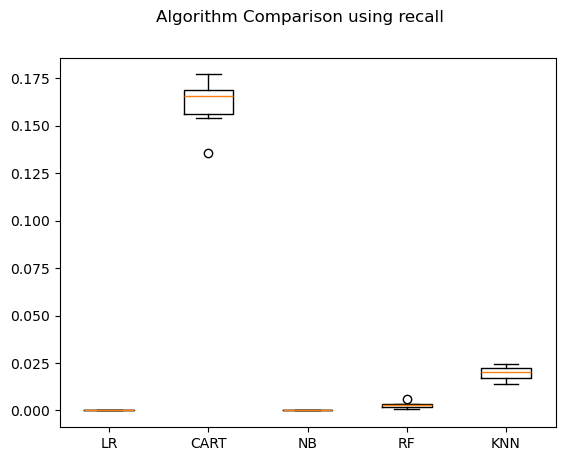

In [50]:
random_state = 12345; n_splits = 10
compare_models(n_splits, random_state, X_, y)

### Observations

As we know, *Recall*, the ability of a classification model to identify all data points in a relevant class is very important to us. 

Based on the above comparison chart, we observe that both Decision Tree (CART) and Random Forest models give better predictions and their recall score is above 16%.

### Let us use Decision Tree model as our Base model

#### Split data into training and test datasets

In [72]:
seed      = 1
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = test_size, random_state = seed, stratify = y) 

### Build Decision Tree model

In [74]:
clf    = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf    = clf.fit(X_train,y_train)

### Predict the response for train dataset

In [76]:
predicted_train = clf.predict(X_train)


Training Data
[[63286     0]
 [    0  7950]]


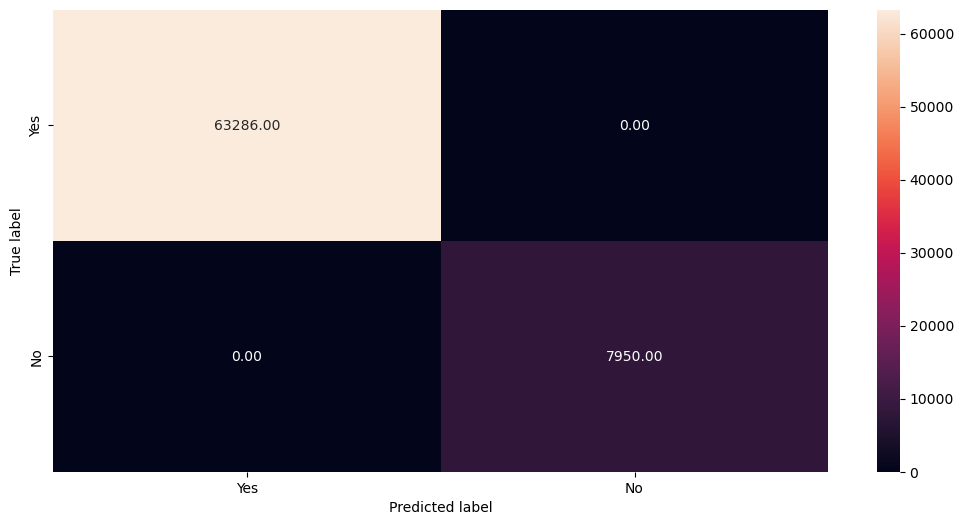

Training Accuracy: 100.000%


In [78]:
matrix             = confusion_matrix(y_train, predicted_train)
print("\nTraining Data")
print(matrix)
draw_cm(y_train, predicted_train)
###     
accuracy_train = clf.score(X_train, y_train) 
print("Training Accuracy: %.3f%%" % (accuracy_train * 100.0))

In [80]:
measures_train     = classification_report(y_train, predicted_train) 
print("\nTraining data")
print(measures_train) 


Training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63286
           1       1.00      1.00      1.00      7950

    accuracy                           1.00     71236
   macro avg       1.00      1.00      1.00     71236
weighted avg       1.00      1.00      1.00     71236



#### Predict the response for test dataset

In [82]:
predicted_testing = clf.predict(X_test)


Testing Data
[[23590  3533]
 [ 2879   528]]


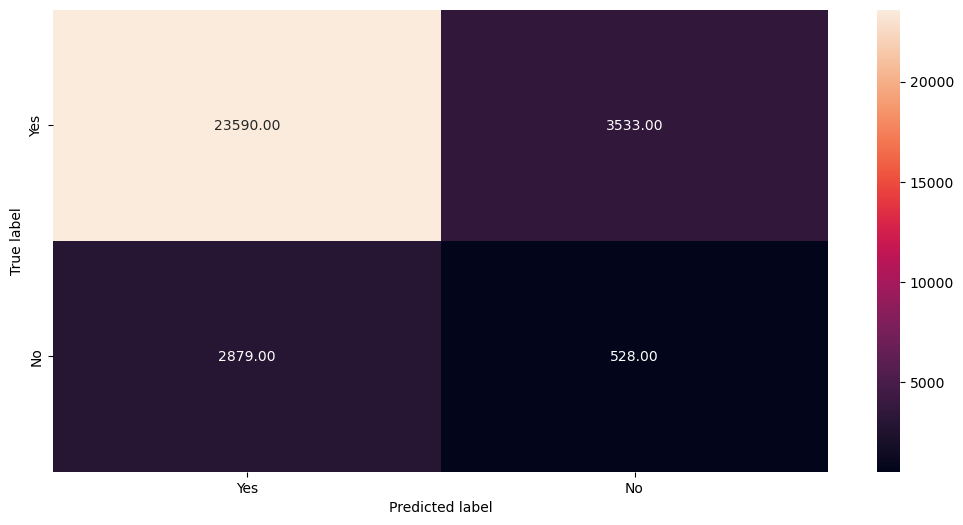

Testing Accuracy: 78.998%


In [84]:
matrix             = confusion_matrix(y_test, predicted_testing)
print("\nTesting Data")
print(matrix)
draw_cm(y_test, predicted_testing )
    
accuracy_train = clf.score(X_test, y_test) 
print("Testing Accuracy: %.3f%%" % (accuracy_train * 100.0))

In [86]:
measures_test     = classification_report(y_test, predicted_testing) 
print("\nTraining data")
print(measures_test) 


Training data
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     27123
           1       0.13      0.15      0.14      3407

    accuracy                           0.79     30530
   macro avg       0.51      0.51      0.51     30530
weighted avg       0.81      0.79      0.80     30530



### Observations

**Recall**

Macro: unweighted mean of all per-class scores.  For training dataset: 100%, For test dataset: 51%

Weighted: mean of all per-class scores, weighted by sample sizes for each class. For training dataset: 100%, For test dataset: 79%

We observe that the performance measures for both training data and test data  shows model overfit.

### It is necessary to try treat data imbalance, hyper-parameter tuning and more models.

### Get insights from the model

Feature importance scores can provide insight into the model. Most importance scores are calculated by a predictive model that has been fit on the dataset. Inspecting the importance score provides insight into that specific model and which features are the most important and least important to the model when making a prediction. This is a type of model interpretation that can be performed for those models that support it.

Ref: https://machinelearningmastery.com/calculate-feature-importance-with-python/

Decision tree algorithms like classification and regression trees (CART) offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy.

In [88]:
flist     = X_.columns
classlist = ['Readmitted', 'Not Readmitted']

In [92]:
current_path = os.environ.get("PATH")
os.environ["PATH"] = current_path + ";C:\\Program Files (x86)\\Graphviz\\bin"

In [96]:
 os.system('dot -Tpng tree.dot -o tree.png')

1

In [100]:
clf1    = DecisionTreeClassifier(max_depth = 4, random_state = 12345).fit(X_train,y_train)

"""

DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)

"""

"\n\nDecisionTreeClassifier(\n    *,\n    criterion='gini',\n    splitter='best',\n    max_depth=None,\n    min_samples_split=2,\n    min_samples_leaf=1,\n    min_weight_fraction_leaf=0.0,\n    max_features=None,\n    random_state=None,\n    max_leaf_nodes=None,\n    min_impurity_decrease=0.0,\n    class_weight=None,\n    ccp_alpha=0.0,\n)\n\n"

In [104]:
tree_to_rules(clf1, flist, classlist)

 if ( time_in_hospital <= 3.5 ) {
   if ( diag_1 <= 707.5 ) {
     if ( num_procedures <= 1.5 ) {
       if ( diag_1 <= 282.5 ) {
         Class = Readmitted
       } else {
         Class = Readmitted
       }
     } else {
       if ( num_lab_procedures <= 35.5 ) {
         Class = Readmitted
       } else {
         Class = Readmitted
       }
     }
   } else {
     if ( diag_2 <= 167.5 ) {
       if ( medical_specialty <= 26.0 ) {
         Class = Not Readmitted
       } else {
         Class = Readmitted
       }
     } else {
       if ( payer_code <= 6.5 ) {
         Class = Readmitted
       } else {
         Class = Readmitted
       }
     }
   }
 } else {
   if ( diag_1 <= 708.5 ) {
     if ( num_medications <= 14.5 ) {
       if ( payer_code <= 11.5 ) {
         Class = Readmitted
       } else {
         Class = Readmitted
       }
     } else {
       if ( payer_code <= 5.5 ) {
         Class = Readmitted
       } else {
         Class = Readmitted
       }
     }
   } e

<function matplotlib.pyplot.show(close=None, block=None)>

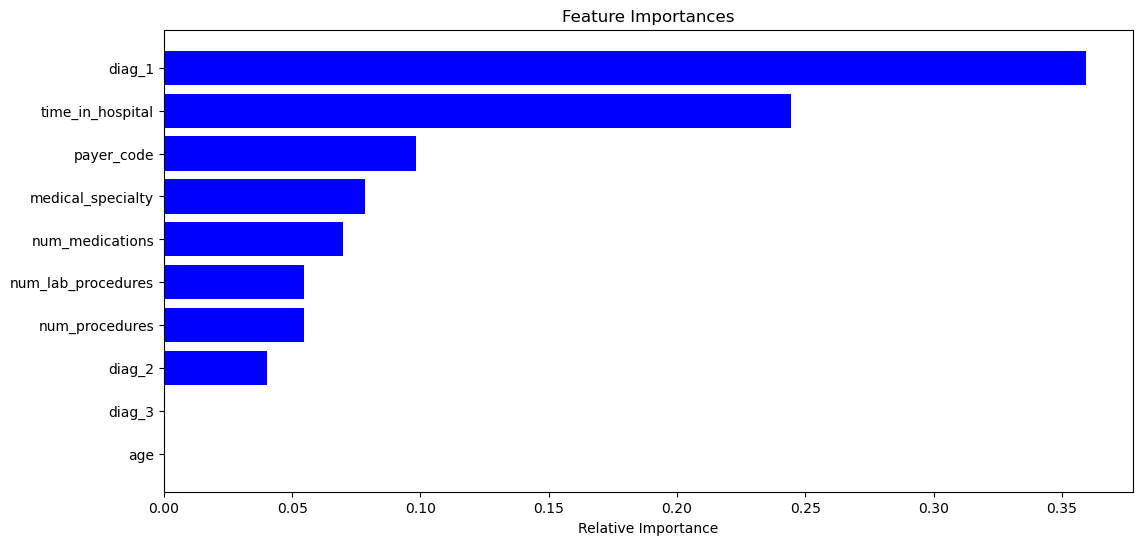

In [106]:
importances = clf1.feature_importances_
indices     = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [flist[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show

In [108]:
idf =  pd.DataFrame({'Name' : [flist[i] for i in indices], 'Value' : importances[indices] *100 })

In [110]:
idf.sort_values('Value', ascending = False, inplace = True)
idf.set_index(keys = 'Name', inplace = True)

In [112]:
idf

,Value
Name,
diag_1,35.960576
time_in_hospital,24.443860
payer_code,9.837218
medical_specialty,7.858944
num_medications,6.979164
num_lab_procedures,5.455779
num_procedures,5.446149
diag_2,4.018310
age,0.000000


Decision trees (CART) offer importance scores based on the reduction in the criterion used to select split points based on entropy.

## END